## Load labelled Tile
No NAN values in dataArray

In [1]:
import rioxarray
import xarray as xr
import numpy as np

In [19]:

dataPath = '/Users/maaikeizeboud/Documents/Data/test/'
imName = 'test_labelled_tile.tif'

In [20]:
tile = rioxarray.open_rasterio(dataPath + imName)
tile.isnull().any()

<xarray.DataArray ()>
array(False)
Coordinates:
    spatial_ref  int64 0

In [33]:
tile

<xarray.DataArray (band: 4, y: 10002, x: 10004)>
array([[[ 9248,  9280, ...,  9232,  9344],
        [ 9336,  9480, ...,  9280,  9328],
        ...,
        [  386,   398, ...,  9608,  9616],
        [  430,   347, ...,  9632,  9632]],

       [[ 9880,  9896, ...,  9496,  9608],
        [ 9856,  9872, ...,  9504,  9616],
        ...,
        [  498,   472, ...,  9856,  9816],
        [  512,   554, ...,  9808,  9880]],

       [[10072, 10088, ...,  9696,  9704],
        [10016, 10104, ...,  9720,  9752],
        ...,
        [  776,   773, ...,  9920,  9920],
        [  726,   785, ...,  9880,  9992]],

       [[    0,     0, ...,     0,     0],
        [    0,     0, ...,     0,     0],
        ...,
        [    0,     0, ...,     0,     0],
        [    0,     0, ...,     0,     0]]], dtype=uint16)
Coordinates:
  * band         (band) int64 1 2 3 4
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

## Make cut-outs with rolling window
### Problem: NaN values appear after  making cutouts 

In [21]:
# initialise rolling object
rolling = tile.rolling(
    x=20,
    y=20,
)
rolling

DataArrayRolling [x->20,y->20]

In [22]:

cutouts = rolling.construct(
    {'x':'x_win', 'y': 'y_win'}, 
    stride={'x': 15, 'y': 15}, # windwo_listing uses 'overlap' of 5, which is a stride of 15 for a window of 20pixels
)

In [23]:
cutouts.shape

(4, 667, 667, 20, 20)

In [24]:
cutouts.isnull().any()

<xarray.DataArray ()>
array(True)
Coordinates:
    spatial_ref  int64 0

#### Example of a cut-out window

In [25]:
# cutouts[0,0,0,:,:] 

### I didn't look good. Franseesco already saw this:
#### issue: cutouts along the edge of the original raster are filled with NaN's


In [26]:
# create combined dimension from x and y ("sample")
cutouts = cutouts.stack(sample=["x", "y"])

In [27]:
cutouts.shape

(4, 20, 20, 444889)

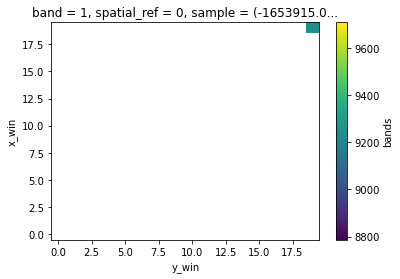

In [28]:
cutouts.attrs["long_name"] = "bands"
cutouts.isel(band=0, sample=0).plot.imshow()

In [29]:
# drop all NaN-containing cutouts - also useful if array has been masked with coastline shape
cutouts = cutouts.dropna(dim="sample", how="any")

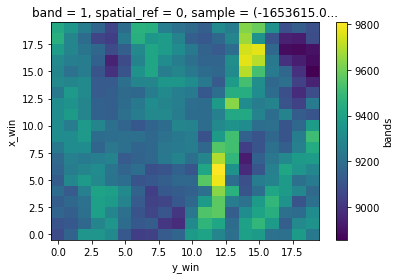

In [31]:
cutouts.isel(band=0, sample=0).plot.imshow()

In [32]:
cutouts.shape # bands, x_win, y_win, sample

(4, 20, 20, 442225)